In [3]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [4]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

# Analysis of the effects of the RIMW on GW gap and excitonic binding energy

We perform a systematic analysis of the effect of the RIMW  procedure. 

To this scope we compare the GW gap at the K point and the first two excitonic binding energies achieved both with and without the RIMW.
The study is performed in functions of the dimension of the k-sampling.

For computational reasons we use small (unconverged) values for the relevant computational parameters. Results are expeced to be non converged,
however we are interested in understanding if the RIMW procedure leads to a faster and reliable convergence of measured quantities in function
of the dimension of the k-points sampling.

In [1]:
kpoints = [30,42,60]

## DFT analysis

In [11]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/qe_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
#code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


We compute the starting point DFT results on a regular grid. 

We use the sg15 pseudo and the associated converged grond state.

We include only 30 bands

In [12]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo_ONCV_PBE_FR-1.0.upf'
S_pseudo = 'S_ONCV_PBE_FR-1.1.upf'
run_dir = 'DFT_analysis-sg15'

alat_conv = 6.014
delta_conv = 0.4932
c = 40.0 # vacuum distance in a.u. 

ecut = 80 # energy cutoff on the wavefunction (Ry)
kp = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut)
inp.set_kpoints(type='automatic',points=kp)
#inp

In [13]:
nbnds = 30
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)

In [14]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kpoints:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis-sg15/gs_converged.save')

Initialize a Dataset with 1 parallel tasks


In [17]:
study.runs[2]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis-sg15',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_60-nbnds_30'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 30,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '2',
   'nat': '3',
   'ibrav': 4,
   'celldm(1)': 6.014,
   'celldm(3)': 6.651147322913202,
   'ecutwfc': 80},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Mo': [42.0, 'Mo_ONCV_PBE_FR-1.0.upf'],
   'S': [16.0, 'S_ONCV_PBE_FR-1.1.upf']},
  'atomic_positions': {'type': 'alat',
   'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
    ['S', array([0.5       , 0.28867513, 0.4932    ])],
    ['S', array([ 0.5       ,  0.28867513, -0.4932    ])]]},
  'kpoints': {'type': 'automatic', 'values': ([60, 60, 1], [0.0, 0.0, 0.0])},
  'cell_paramete

In [18]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
copy source_dir DFT_analysis-sg15/gs_converged.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_30-nbnds_30.save
run command: mpirun -np 16 pw.x -inp kpoints_30-nbnds_30.in > kpoints_30-nbnds_30.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_kpoints_30-nbnds_30.sh
computation kpoints_30-nbnds_30 is running...
computation kpoints_30-nbnds_30 ended
Task [0] ended 
 
Run the task [1] 
copy source_dir DFT_analysis-sg15/gs_converged.save in the /work/dalessandro/TMDs/MoS2/DFT_analysis-sg15/kpoints_42-nbnds_30.save
run command: mpirun -np 16 pw.x -inp kpoints_42-nbnds_30.in > kpoints_42-nbnds_30.log
slurm submit:  cd DFT_analysis-sg15 ; sbatch job_kpoints_42-nbnds_30.sh
computation kpoints_42-nbnds_30 is running...
computation kpoints_42-nbnds_30 ended
Task [1] ended 
 
Run the task [2] 
copy source_dir DFT_analysis-sg15/gs_converged.save in the /work/dalessandro/TMDs/MoS2/DFT

## GW analysis

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
#code.global_options()

We study the convergence of the GW gap at the K point.

Note that the cutoff of the various computational parameters have been reduced

In [23]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 26,27
K_index = {30:91,42:169,60:331,90:None}
RandGvec = 100
Randqpts = 5e6
RandGvecW = 5
EXXRLvcs = 10 # 30. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 2.0 # 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,30]# Bands in the response function
GbndRnge = [1,30] # Bands in the Sigma_c

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis-sg15/kpoints_%s-nbnds_30.save'%k
    run_dir = 'MB_analysis/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

    inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_bandRange(start_band,stop_band)
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    
    # append run at K
    inp.set_kRange(K_index[k],K_index[k])
    inp.deactivate_RIM_W()
    idd = 'pp-K-kpoints_%s'%k
    jobname = [idd,'ndbs']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname)
    inp.activate_RIM_W()
    idd = 'pp-K-kpoints_%s-RIM_W'%k
    jobname = [idd,'ndbs']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)

16 1
Initialize a Dataset with 1 parallel tasks
SAVE folder MB_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_60-nbnds_30/SAVE already present. No operations performed.


In [24]:
study.ids

['pp-K-kpoints_30',
 'pp-K-kpoints_30-RIM_W',
 'pp-K-kpoints_42',
 'pp-K-kpoints_42-RIM_W',
 'pp-K-kpoints_60',
 'pp-K-kpoints_60-RIM_W']

In [27]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'MB_analysis/kpoints_30-nbnds_30',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -r -k hartee -dyson n -gw0 p -V all',
  'folder': 'MB_analysis/kpoints_30-nbnds_30',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'em1d', 'gw0', 'HF_and_locXC', 'ppa', 'ExtendOut'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [26.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [80240.0, 'Kb'],
   'FFTGvecs': [18825.0, 'RL'],
   'X_and_IO_nCPU_LinAlg_INV': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'DIP_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [100, 'RL'],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [10, 'Ha'],
   'VXCRLvcs': [83877.0, 'RL'],
   'XfnQP_INTERP_NN': [1.0, ''],
   'XfnQP_INTERP_shells': [20.0, ''],
   'XfnQP_Wv_E

In [8]:
results = study.run(selection=[0,2,4])

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]] 

Run the task [0, 1] 
Skip the run of pp-G-kpoints_18Skip the run of
 pp-G-kpoints_18-RIM_W
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-K-kpoints_18Skip the run of
 pp-K-kpoints_18-RIM_W
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-kpoints_30Skip the run of
 pp-G-kpoints_30-RIM_W
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-K-kpoints_30Skip the run of
 pp-K-kpoints_30-RIM_W
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-kpoints_42Skip the run of
 pp-G-kpoints_42-RIM_W
Task [8, 9] ended 
 
Run the task [10, 11] 
Skip the run of pp-K-kpoints_42
Skip the run of pp-K-kpoints_42-RIM_W
Task [10, 11] ended 
 


In [9]:
results_K = [results[r] for r in [0,2,4]]
results_K_rimw = [results[r] for r in [1,3,5]]

In [11]:
gap_K, gap_K_rimw = [],[]
for ind,k in enumerate(kpoints):
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
    gap_K_rimw.append(results_K_rimw[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_K, gap_K_rimw

([3.088822, 2.894613, 2.822524], [2.7199869999999997, 2.713771, 2.713503])

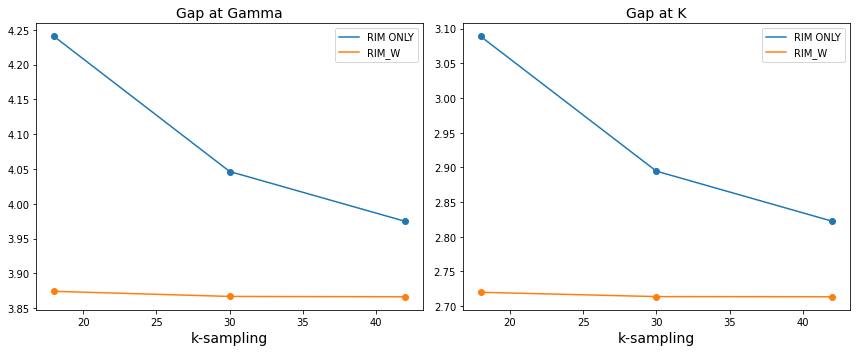

In [12]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(kpoints, gap_K,label='RIM ONLY')
ax.scatter(kpoints,gap_K)
ax.plot(kpoints, gap_K_rimw,label='RIM_W')
ax.scatter(kpoints,gap_K_rimw)
ax.set_title('Gap at K',size=14)
ax.set_xlabel('k-sampling',size=14)
ax.legend()